# Problem 1

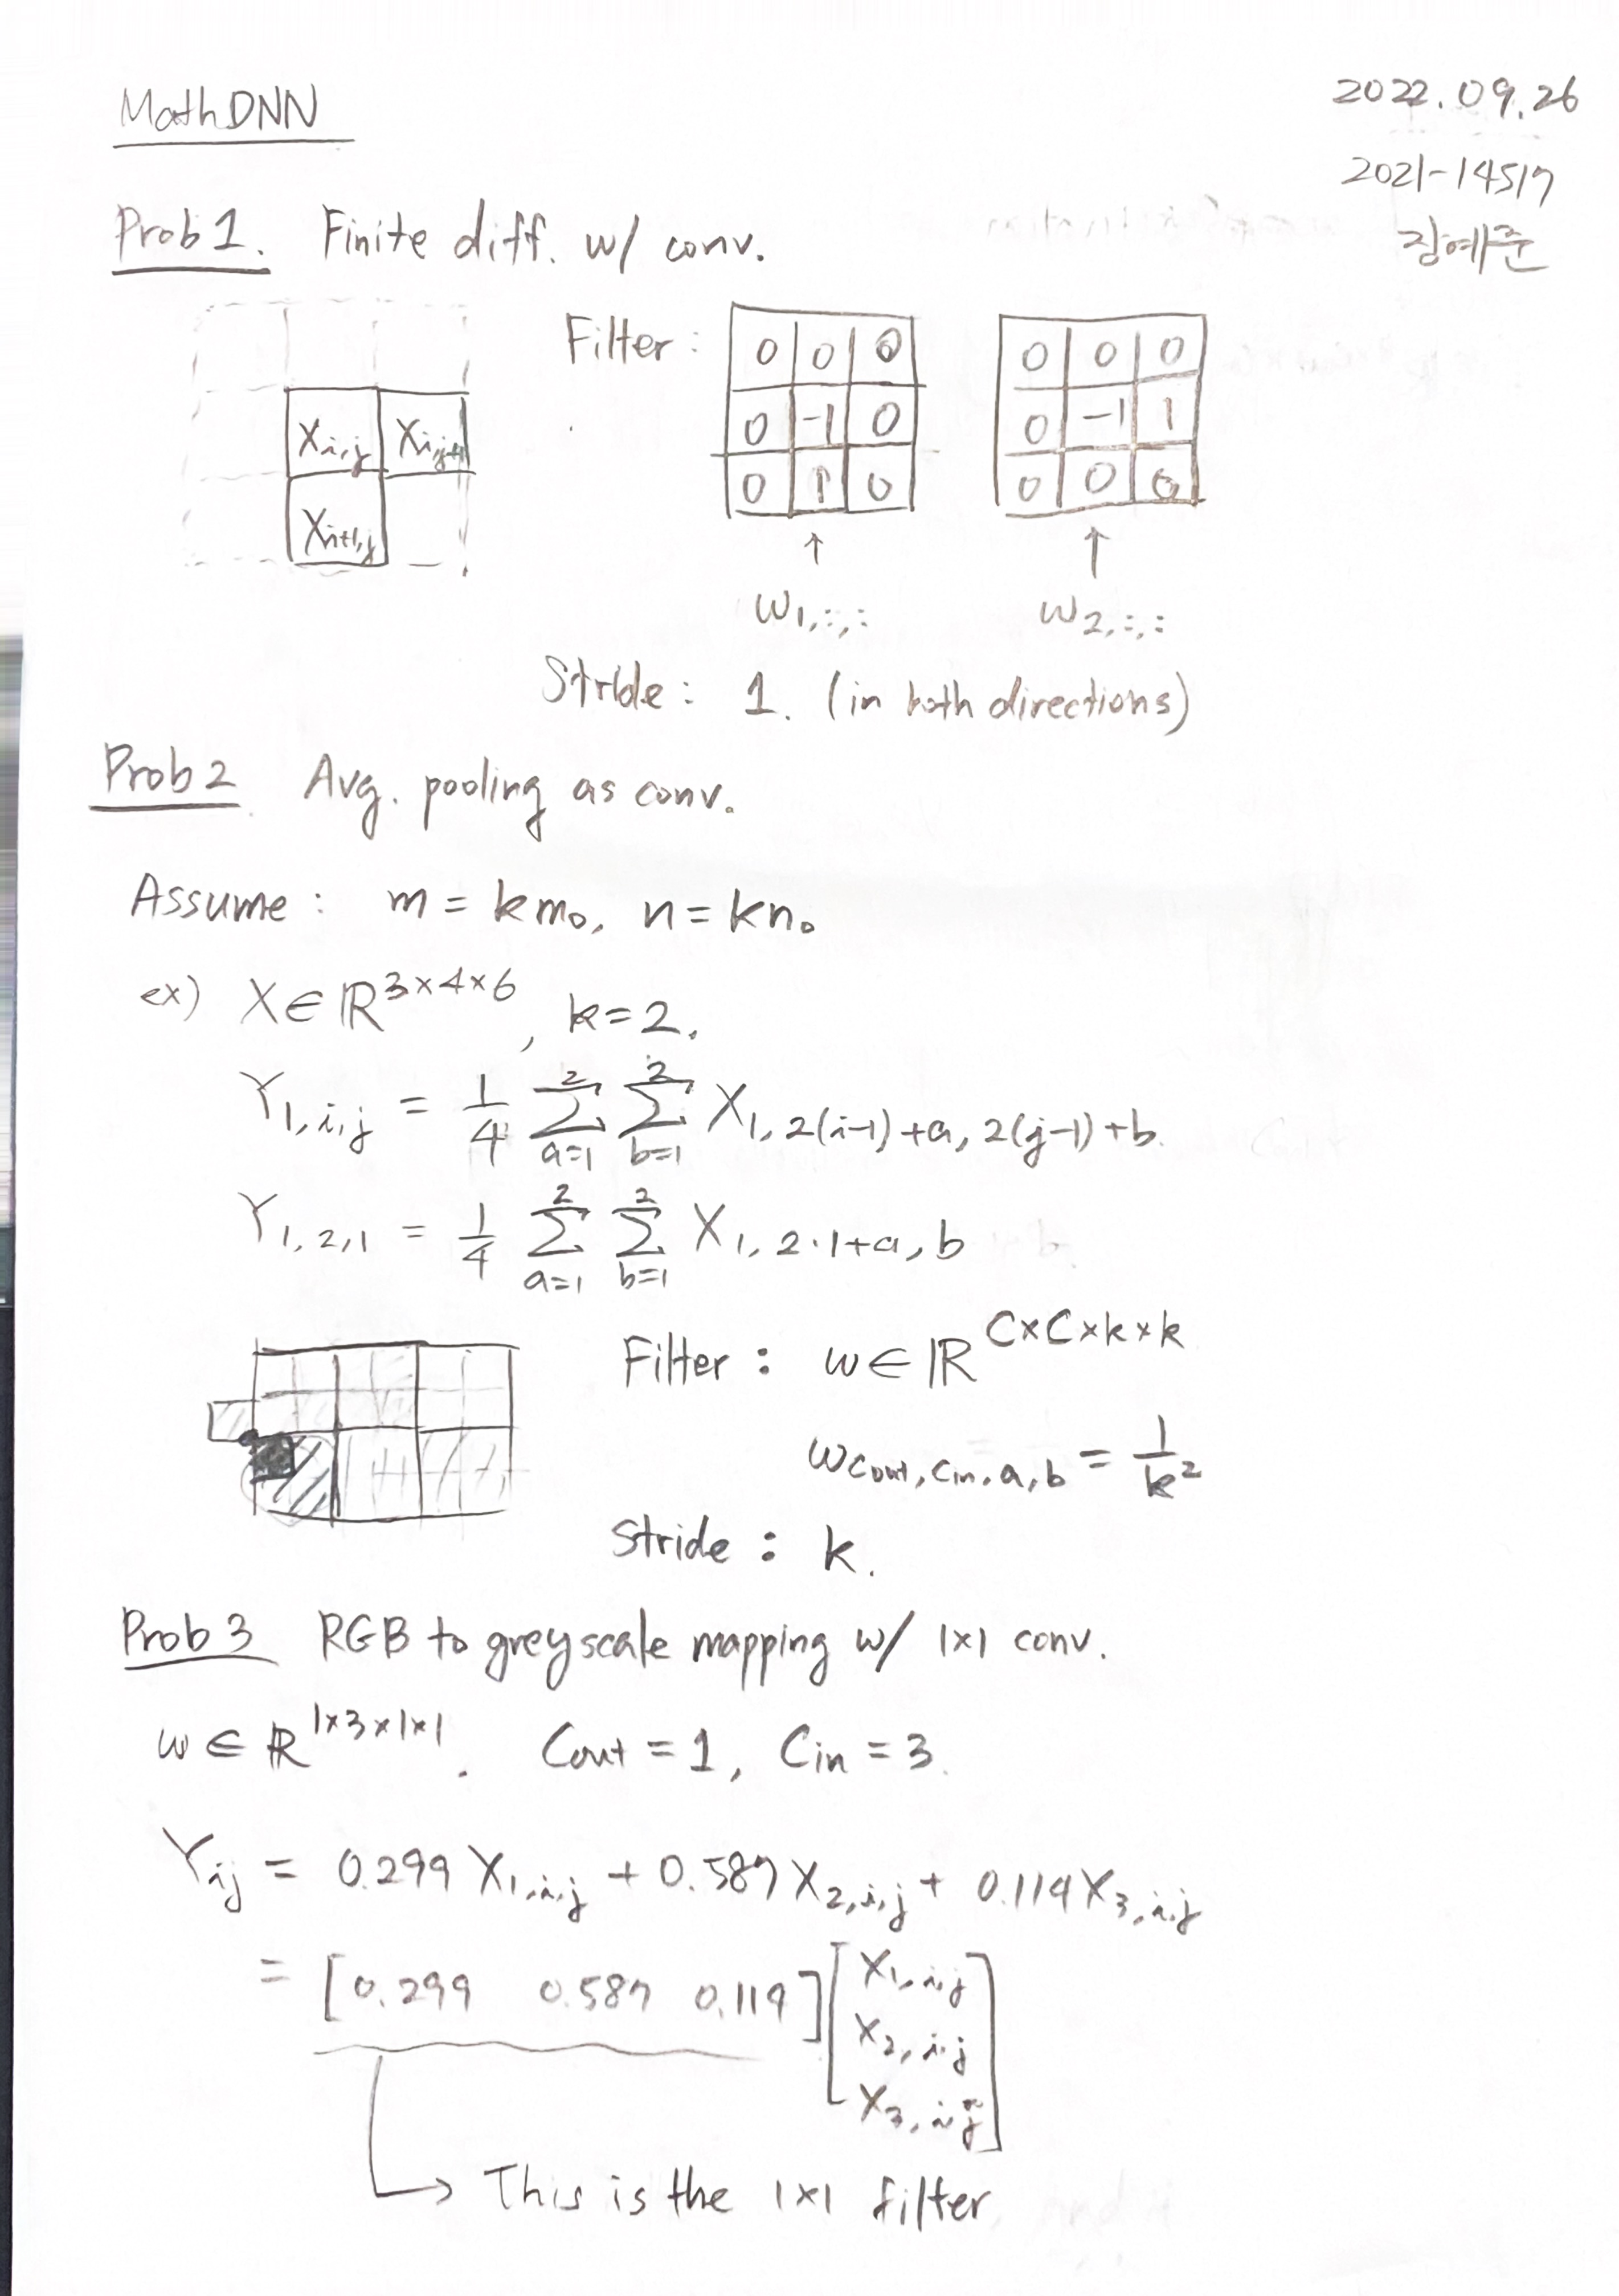

# Problem 5

In [19]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import transforms

from random import randint
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

is_MSE_loss = True

In [20]:
'''
Step 1: Prepare dataset
'''

label_1, label_2 = 4, 9

train_set = datasets.MNIST(root='./mnist_data', train=True, transform=transforms.ToTensor(), download=True)
idx = (train_set.targets==label_1) + (train_set.targets==label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets==label_1] = -1
train_set.targets[train_set.targets==label_2] = 1

test_set = datasets.MNIST(root='./mnist_data', train=False, transform=transforms.ToTensor())
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets==label_1] = -1
test_set.targets[test_set.targets==label_2] = 1


In [21]:
'''
Step 2: Define the neural network class
'''

class LR(nn.Module):
    def __init__(self, input_dim=28*28):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
    def forward(self, x):
        return self.linear(x.float().view(-1, 28*28))

In [22]:
'''
Step 3: Create the model, specify loss function and optimizer
'''
model = LR()

def logistic_loss(output, target):
    if is_MSE_loss == False:
        return -torch.nn.functional.logsigmoid(target*output)
    else:
        z, y = output, target
        first_term = 1/2*(1-y)*((1-torch.sigmoid(-z))**2 + (torch.sigmoid(z))**2)
        second_term = 1/2*(1+y)*((torch.sigmoid(-z))**2 + (1-torch.sigmoid(z))**2)
        return first_term + second_term

loss_function = logistic_loss
optimizer = torch.optim.SGD(model.parameters(), lr=5e-6)

In [23]:
'''
Step 4: Train model with SGD
'''
import time
start = time.time()
for _ in range(1000):
    ind = randint(0, len(train_set.data))
    image, label = train_set.data[ind], train_set.targets[ind]
    
    optimizer.zero_grad()
    
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()
    
    optimizer.step()

end = time.time()
print(f"Time ellapsed in training is: {end-start}")

Time ellapsed in training is: 0.33979082107543945


In [24]:
'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

for ind in range(len(test_set.data)):
    image, label = test_set.data[ind], test_set.targets[ind]
    output = model(image)
    test_loss += loss_function(output, label.float()).item()
    
    if output.item() * label.item() >= 0:
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} {:.2f}%\n'.format(
test_loss / len(test_set.data), correct, len(test_set.data), 100 * correct / len(test_set.data)
))

[Test set] Average loss: 0.6301, Accuracy: 1348/1991 67.70%



### Performance comparison, compared to minimizing KL divergence
The performance is much worse when minimizing the MSELoss, compared to  minimizing the KL divergence.
Using MSELoss is a bad idea, especially because of task that the model needs to perform. The problem we're facing is a "binary classification" problem. Using the MSELoss assumes that $Y_i$ can take on continuous values, and that the $Y_i$'s follow a normal distribution centered around some mean value. This isn't the case for binary classification \- the labels are discrete and can take on only two values, i.e. $Y_i$'s follow a Bernoulli distribution with success probability $p\approx0.5$.